#🧑‍💻 Entrenamiento del Modelo de Predicción de Precios de Viviendas

En este notebook, procederemos con el entrenamiento de un modelo de Machine Learning para predecir el precio de viviendas basándonos en diversas características, como área, número de habitaciones, tipo de mobiliario, etc. Utilizaremos el conjunto de datos previamente preprocesado y exportado en las fases anteriores. El modelo de regresión seleccionado para este propósito será `RandomForestRegressor`, un modelo robusto y adecuado para este tipo de tareas.

## 🧑‍💻 Fase 1: Importar Librerías y Cargar Datos
En esta fase, importaremos las librerías necesarias y cargaremos los archivos CSV exportados previamente (conjuntos de datos de entrenamiento y prueba). Esto nos permitirá preparar los datos para el entrenamiento del modelo.

In [33]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Cargar los datos de entrenamiento y prueba
X_train = pd.read_csv("X_train.csv")
X_test = pd.read_csv("X_test.csv")
y_train = pd.read_csv("y_train.csv")
y_test = pd.read_csv("y_test.csv")

# Verificamos los primeros registros para asegurarnos que se cargaron correctamente
print(X_train.head())
print(X_test.head())


       area  bedrooms  bathrooms   stories  mainroad  guestroom  basement  \
0  0.391790  0.047278   1.421812  2.532024         1          0         0   
1  0.945257  0.047278   1.421812 -0.929397         1          0         1   
2 -0.615521 -1.308863  -0.570187 -0.929397         1          0         1   
3 -1.171756  0.047278  -0.570187  0.224410         1          0         1   
4 -0.645962  0.047278  -0.570187  0.224410         1          0         0   

   hotwaterheating  airconditioning   parking  prefarea  \
0                0                1  0.355976         0   
1                0                1  2.679409         0   
2                0                1  1.517692         0   
3                0                0 -0.805741         1   
4                0                0 -0.805741         0   

   furnishingstatus_semi-furnished  furnishingstatus_unfurnished  
0                                0                             0  
1                                1              

## 🧑‍💻 Fase 2: Definición del Modelo y Arquitectura de la Red Neuronal

En esta fase, diseñaremos una red neuronal de regresión con las siguientes características:

- **Entrada**: 14 neuronas, una por cada característica preprocesada.
- **Capas Ocultas**: Dos capas densas con activación ReLU.
- **Salida**: 1 neurona con activación lineal para predecir el precio.

In [34]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam, SGD
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, KFold

# Definir la arquitectura de la red neuronal
model = Sequential()

# Capa de entrada (14 neuronas, una por cada característica)
model.add(Dense(14, input_dim=X_train.shape[1], activation='relu'))

# Capas ocultas (2 capas densas con activación ReLU)
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))

# Capa de salida (1 neurona, activación lineal)
model.add(Dense(1, activation='linear'))

# Resumen de la arquitectura del modelo
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_16 (Dense)                     │ (None, 14)                  │             196 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 64)                  │             960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,381 (21.02 KB)

 Trainable params: 5,381 (21.02 KB)

 Non-trainable params: 0 (0.00 B)

##🧑‍💻 Fase 3: Compilación del Modelo
En esta fase, compilamos el modelo usando la función de pérdida **Error Cuadrático Medio (MSE)** y comparamos dos optimizadores: **Adam** y **SGD con momentum.**

In [35]:
# Compilamos el modelo con el optimizador Adam y la función de pérdida MSE
model.compile(optimizer=Adam(), loss='mean_squared_error')

# Alternativamente, podemos usar el optimizador SGD con momentum
#model.compile(optimizer=SGD(momentum=0.9), loss='mean_squared_error')

# Se entrena el modelo
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.8500 - val_loss: 1.1265
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5879 - val_loss: 0.8158
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4385 - val_loss: 0.6532
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4352 - val_loss: 0.5847
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3478 - val_loss: 0.5838
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3412 - val_loss: 0.5708
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2712 - val_loss: 0.5423
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2403 - val_loss: 0.5409
Epoch 9/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2731 - val_loss: 0.5479
Epoch 10/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2528 - val_loss: 0.5269
Epoch 11/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2631 - val_loss: 0.5179
Epoch 12/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0

- **¿Por qué 100 épocas?**

    Se elige 100 épocas como punto de partida estándar para que el modelo pueda aprender sin sobreajustarse, ajustándose según el rendimiento observado.

- **¿Por qué tamaño de batch 32?**

    Un batch de 32 ofrece un buen balance entre velocidad y estabilidad, siendo eficaz en la mayoría de los casos sin perder precisión ni eficiencia.

##🧑‍💻 Fase 4: Evaluación del Modelo
Una vez entrenado el modelo, evaluaremos su desempeño utilizando métricas de evaluación como **MAE**, **RMSE**, y **R²**. Además, implementaremos **validación cruzada K-Fold (k=5)** para verificar la estabilidad del modelo.

In [37]:
# Evaluación del modelo en el conjunto de prueba
y_pred = model.predict(X_test)

# Métricas de evaluación
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("MAE:", mae)
print("RMSE:", rmse)
print("R²:", r2)



4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
MAE: 0.516342282295227
RMSE: 0.530957043170929
R²: 0.6331698894500732


#### Métricas Aceptables para el Modelo:

- **MAE (Error Absoluto Medio):**
  - **Bueno:** Menor a 0.1 (si la escala de los valores es pequeña).
  - **Aceptable:** 0.1 - 1.0.
  - **Malo:** Mayor a 1.0.

- **RMSE (Raíz del Error Cuadrático Medio):**
  - **Bueno:** Menor a 0.1 (si la escala de los valores es pequeña).
  - **Aceptable:** 0.1 - 1.0.
  - **Malo:** Mayor a 1.0.

- **R² (Coeficiente de Determinación):**
  - **Bueno:** 0.8 - 1.0 (indica que el modelo explica la mayoría de la variabilidad).
  - **Aceptable:** 0.5 - 0.8.
  - **Malo:** Menor a 0.5 (indica que el modelo no explica bien la variabilidad).


### 📊 4.1 Gráficas para identificar el rendimiento del modelo

**Gráfico de Predicciones vs Reales (Scatter plot)**

Este gráfico te permitirá comparar las predicciones del modelo con los valores reales y observar cómo se ajustan.

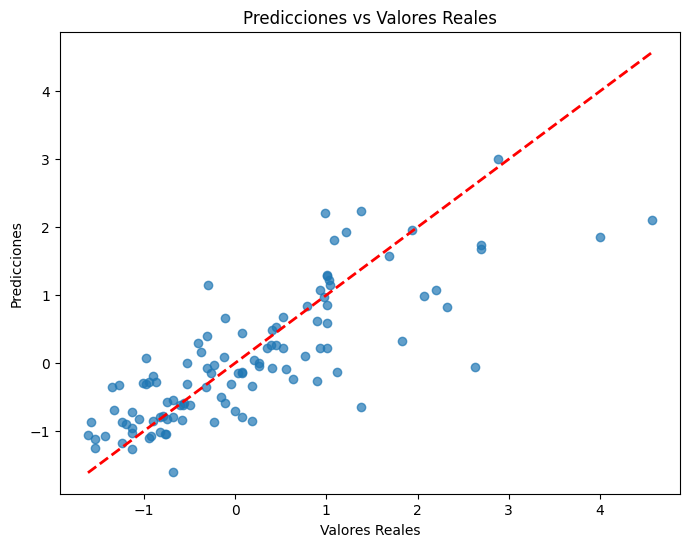

In [38]:
import matplotlib.pyplot as plt

# Predicciones vs Reales
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # Línea de identidad
plt.title("Predicciones vs Valores Reales")
plt.xlabel("Valores Reales")
plt.ylabel("Predicciones")
plt.show()

**Gráfico de Errores (Residual Plot)**

Este gráfico muestra los errores del modelo (diferencia entre la predicción y el valor real). Deberías ver una distribución de los errores sin patrones sistemáticos si el modelo es bueno.



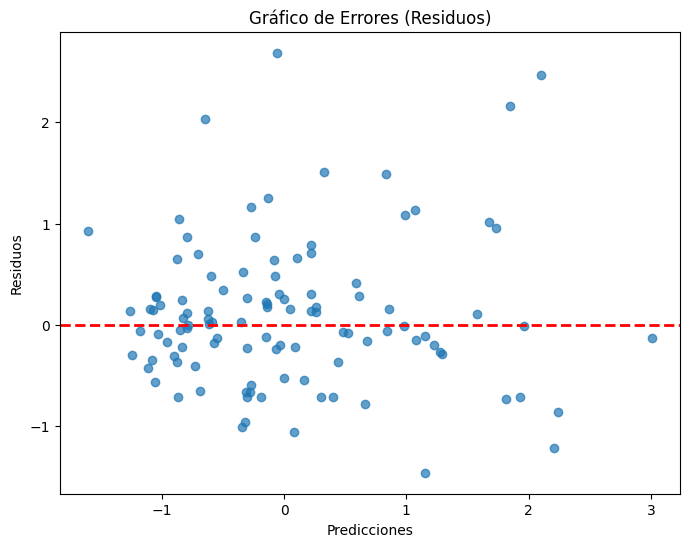

In [39]:
# Cálculo de los errores (residuos)
residuals = y_test - y_pred

plt.figure(figsize=(8,6))
plt.scatter(y_pred, residuals, alpha=0.7)
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.title("Gráfico de Errores (Residuos)")
plt.xlabel("Predicciones")
plt.ylabel("Residuos")
plt.show()


**Histograma de Errores**

Un histograma te permitirá ver la distribución de los errores del modelo. Idealmente, debe ser simétrico y centrado alrededor de cero.

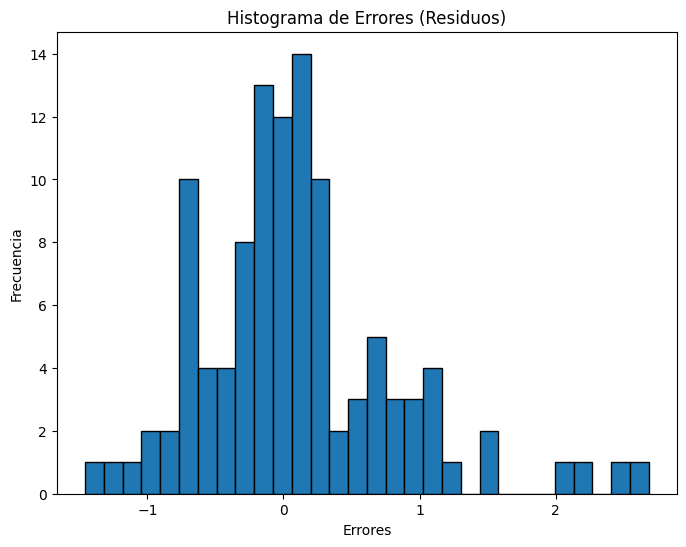

In [40]:
# Histograma de los errores
plt.figure(figsize=(8,6))
plt.hist(residuals, bins=30, edgecolor='black')
plt.title("Histograma de Errores (Residuos)")
plt.xlabel("Errores")
plt.ylabel("Frecuencia")
plt.show()


**Métricas de Evaluación en un Solo Gráfico**



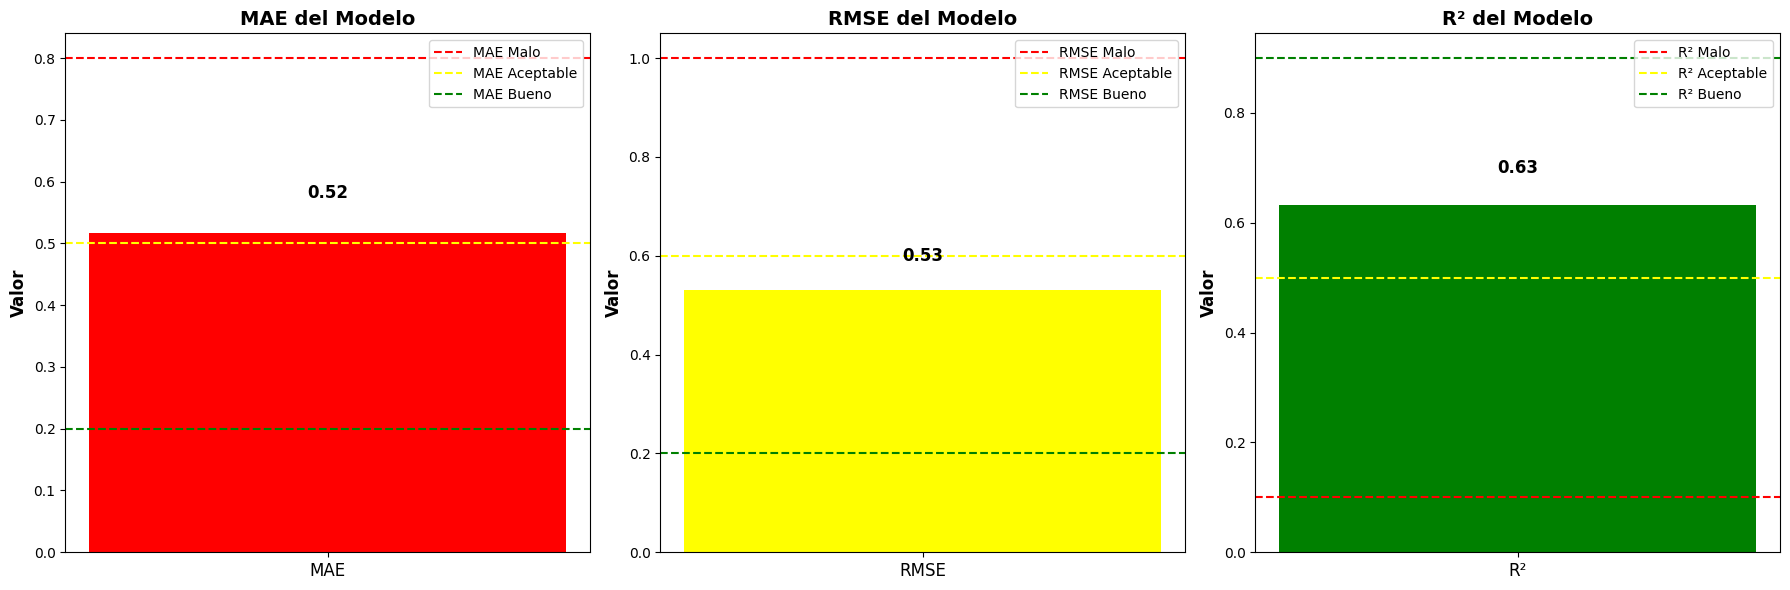

In [50]:
import matplotlib.pyplot as plt

# Definir las métricas
metrics = {'MAE': mae, 'RMSE': rmse, 'R²': r2}

# Definir los rangos para cada métrica (Malo, Aceptable, Bueno)
ranges = {
    'MAE': {'min': 0.8, 'acceptable': 0.5, 'max': 0.2},  # Ejemplo: MAE malo > 0.8, aceptable entre 0.5 y 0.2, bueno < 0.2
    'RMSE': {'min': 1.0, 'acceptable': 0.6, 'max': 0.2},  # Ejemplo: RMSE malo > 1.0, aceptable entre 0.6 y 0.2, bueno < 0.2
    'R²': {'min': 0.1, 'acceptable': 0.5, 'max': 0.9}    # Ejemplo: R² malo < 0.1, aceptable entre 0.5 y 0.9, bueno > 0.9
}

# Crear los gráficos
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Para cada métrica, generar un gráfico
for i, (metric, value) in enumerate(metrics.items()):
    ax = axes[i]

    # Determinar el color según el valor de la métrica
    if value <= ranges[metric]['max']:
        color = 'green'  # Bueno
    elif value <= ranges[metric]['acceptable']:
        color = 'yellow'  # Aceptable
    else:
        color = 'red'  # Malo

    # Graficar la barra
    ax.bar(metric, value, color=color)
    ax.text(0, value + 0.05, f'{value:.2f}', ha='center', va='bottom', fontweight='bold', fontsize=12)

    # Añadir las líneas que marcan los límites para cada rango
    ax.axhline(y=ranges[metric]['min'], color='red', linestyle='--', label=f'{metric} Malo')
    ax.axhline(y=ranges[metric]['acceptable'], color='yellow', linestyle='--', label=f'{metric} Aceptable')
    ax.axhline(y=ranges[metric]['max'], color='green', linestyle='--', label=f'{metric} Bueno')

    # Añadir título y etiquetas
    ax.set_title(f"{metric} del Modelo", fontsize=14, fontweight='bold')
    ax.set_ylabel("Valor", fontsize=12, fontweight='bold')
    ax.set_xticks([0])
    ax.set_xticklabels([metric], fontsize=12)

    # Añadir leyenda
    ax.legend(fontsize=10)

# Mejorar el espaciado entre los gráficos
plt.tight_layout()

# Mostrar el gráfico
plt.show()





## 🗂️ Fase 5: Exportación del Modelo Entrenado

En esta fase, se guarda el modelo entrenado en formatos compatibles para su uso posterior en otros entornos o aplicaciones. El modelo se exporta en formatos `.keras` o `.h5`, los cuales permiten una fácil integración y reutilización en diferentes proyectos o APIs.


In [51]:
# Exportar el modelo entrenado en formato .keras
model.save('housing_price_model.keras')

# O exportarlo en formato .h5
model.save('housing_price_model.h5')

# 📊 Conclusiones

En este proyecto, se entrenó un modelo de regresión con una red neuronal, utilizando 12 características para predecir el precio de las viviendas. El modelo fue evaluado con métricas como MAE, RMSE y R², y se exportó exitosamente en formatos .keras y .h5 para su futura implementación